<a href="https://colab.research.google.com/github/Kuzay3t/2D-Image-Reconstruction/blob/main/2d_image_reconstruction_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# importing libaries - pytorch libary was used

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

In [12]:
# Download MNIST dataset
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

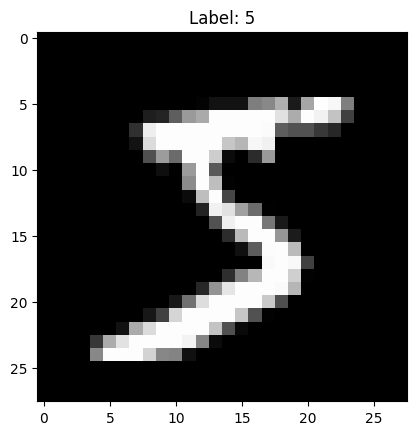

In [13]:
# sampling an image
image, label = train_dataset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [14]:
# adding noise to the image
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * torch.randn_like(images)
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [15]:
# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        # Encoder: reduces image to a small feature set
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # (batch, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (batch, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                      # (batch, 64, 1, 1)
            nn.ReLU()
        )
        # Decoder: reconstructs image from features
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),             # (batch, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (batch, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # (batch, 1, 28, 28)
            nn.Sigmoid()  # output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
# Create our model
model = SimpleAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# Training
num_epochs = 5
for epoch in range(num_epochs):
    for images, _ in train_loader:
        noisy_images = add_noise(images)
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # target is the clean image
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 0.0209
Epoch [2/5], Loss: 0.0191
Epoch [3/5], Loss: 0.0151
Epoch [4/5], Loss: 0.0123
Epoch [5/5], Loss: 0.0142


In [19]:
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        noisy_images = add_noise(images)
        outputs = model(noisy_images)
        break  # just one batch

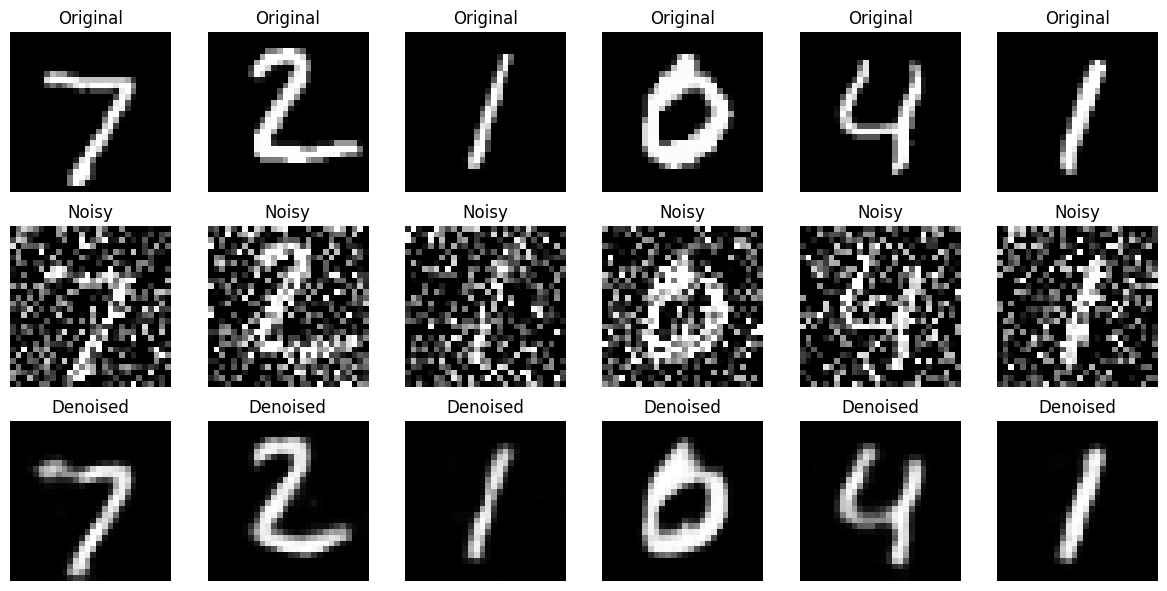

In [20]:
fig, axes = plt.subplots(3, 6, figsize=(12,6))
for i in range(6):
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
    axes[2, i].set_title("Denoised")
    axes[2, i].axis('off')
plt.tight_layout()
plt.show()